# Assignment 3 - Version Samy

In [1]:
############
# Packages #
############
import os
import sys
import scipy
import librosa
import geopandas
import contextily as cx

import datetime as dt
import ruptures as rpt
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import product
from IPython.display import Audio 
from IPython.core.display import display

from pygsp import graphs
from collections import Counter
from tqdm.notebook import tqdm
from math import asin, cos, radians, sin, sqrt

from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import mean_squared_error
from prettytable import PrettyTable
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from typing import Dict, Union, List, Tuple, Any, Callable, Optional
pio.renderers.default = "plotly_mimetype+notebook"

rng = np.random.default_rng()

C:\Users\hocin\AppData\Local\Temp\ipykernel_84624\1398283141.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
###################
#   ploting st    #
###################

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

#Color
def my_pal(n):
    return sns.color_palette("Spectral", n).as_hex()

#Simple
def plot_signal(vec, title = "signal"):
    fig = px.line(vec, template = "plotly_dark", title = title)
    fig.show()
    
def plot_all_st(X, clustering=None, title="<b>Signals</b>"):
    """
    Plot multiple signals in a single interactive Plotly figure.

    Args:
        X (list of arrays): A list of signal arrays to be plotted.
        clustering (list or None, optional): A list of cluster assignments for each signal. 
            If provided, signals will be color-coded by cluster. Default is None.
        title (str, optional): The title of the plot. Default is "<b>Signals</b>".

    Returns:
        None: Displays an interactive Plotly figure with the plotted signals.
    """
    
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
        
    if clustering:
        pal = ["palegreen", "darkred"]
    else:
        pal = sns.color_palette("Spectral", len(X)).as_hex()

    for i in range(len(X)):
        if clustering:
            color = pal[clustering[i]]
        else:
            color = pal[i]
            
        fig.add_trace(go.Scatter(y=X[i], 
                                 mode="lines", 
                                 line=dict(
                                     width=2,
                                     color=color,
                                 ),
                                 opacity = 0.6
                                ))
    fig.show()
# Constructor
def add_fig(fig, signal, color, name):
    fig.add_trace(go.Scatter(y=signal, 
                 mode="lines", 
                 line=dict(
                     width=2,
                     color=color,
                 ),
                 opacity = 0.6,
                 name=name
                )
             )
    

#Two signals compairison
def plot_estim(xb, true_x, title = "estimate xbar", name1 = f"Estimation", name2 = f"Signal"):
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
    pal = my_pal(4)

    add_fig(fig, xb, "darkorchid" ,name1)
    add_fig(fig, true_x, "palegreen" ,name2)
    fig.show()

def plot_spectrogram(f, t, Sxx, title = "Spectrogram"):
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.show()


## Question 3

In [157]:
def g_u(λ, R, a):
    return 1*(-R*a <= λ < 0)*(1 + np.cos(2*np.pi*(λ/(a*R) + 1/2)))/2

def g_m(m, λ, λ_n, M, R):
    if not (0 <= λ <= λ_n):
        return 0
    a = λ_n/(M+1-R)
    return g_u(λ - a*m, R, a)


In [4]:
M = 9
λ_n = 12
λ = np.linspace(0, λ_n, 100)
m = 1

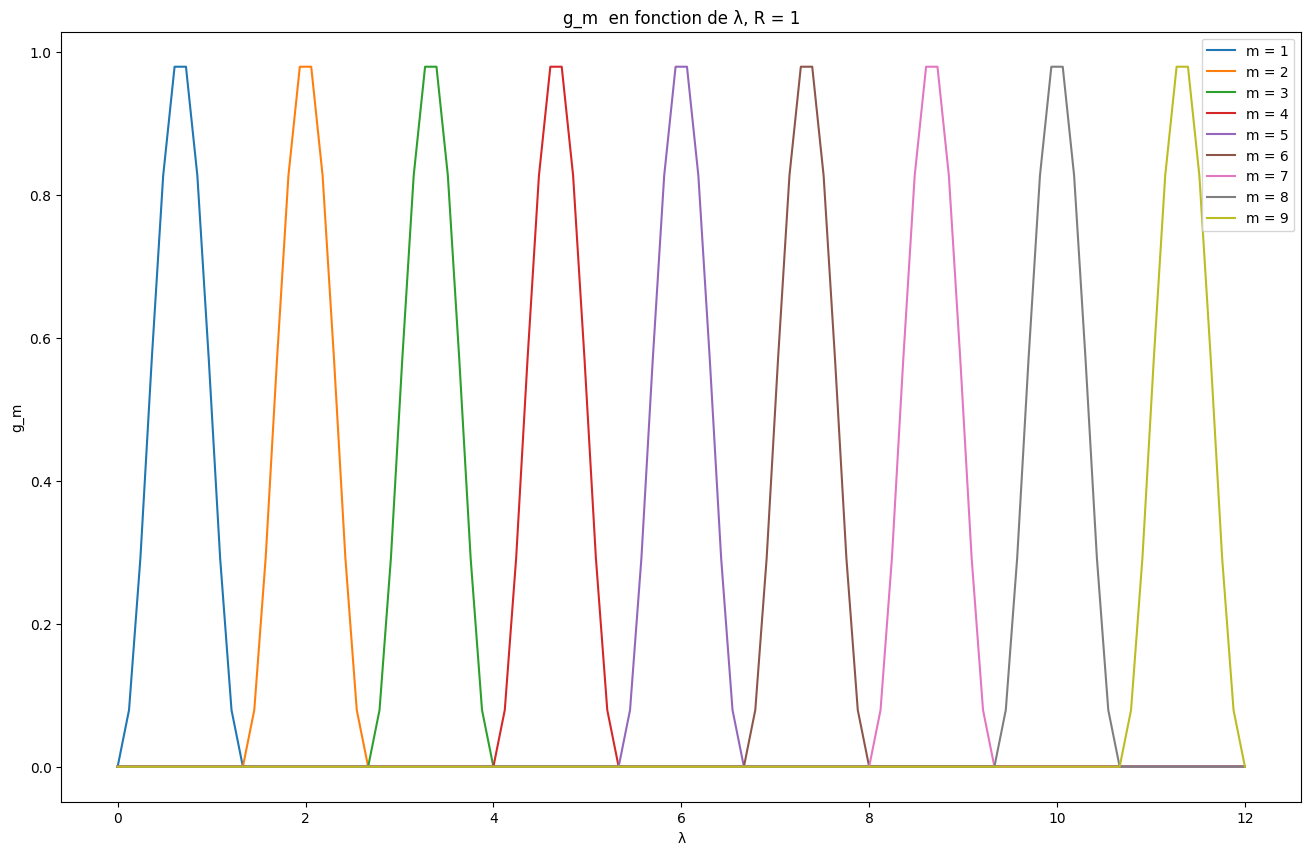

In [158]:
R = 1

plt.figure(figsize=(16, 10))
for m in range(1, M+1):
    plt.plot(λ,[g_m(m, lbd, λ_n, M, R) for lbd in λ], label = f"m = {m}")
plt.xlabel("λ")
plt.ylabel("g_m")
plt.title(label=f"g_m  en fonction de λ, R = {R}")
plt.legend()

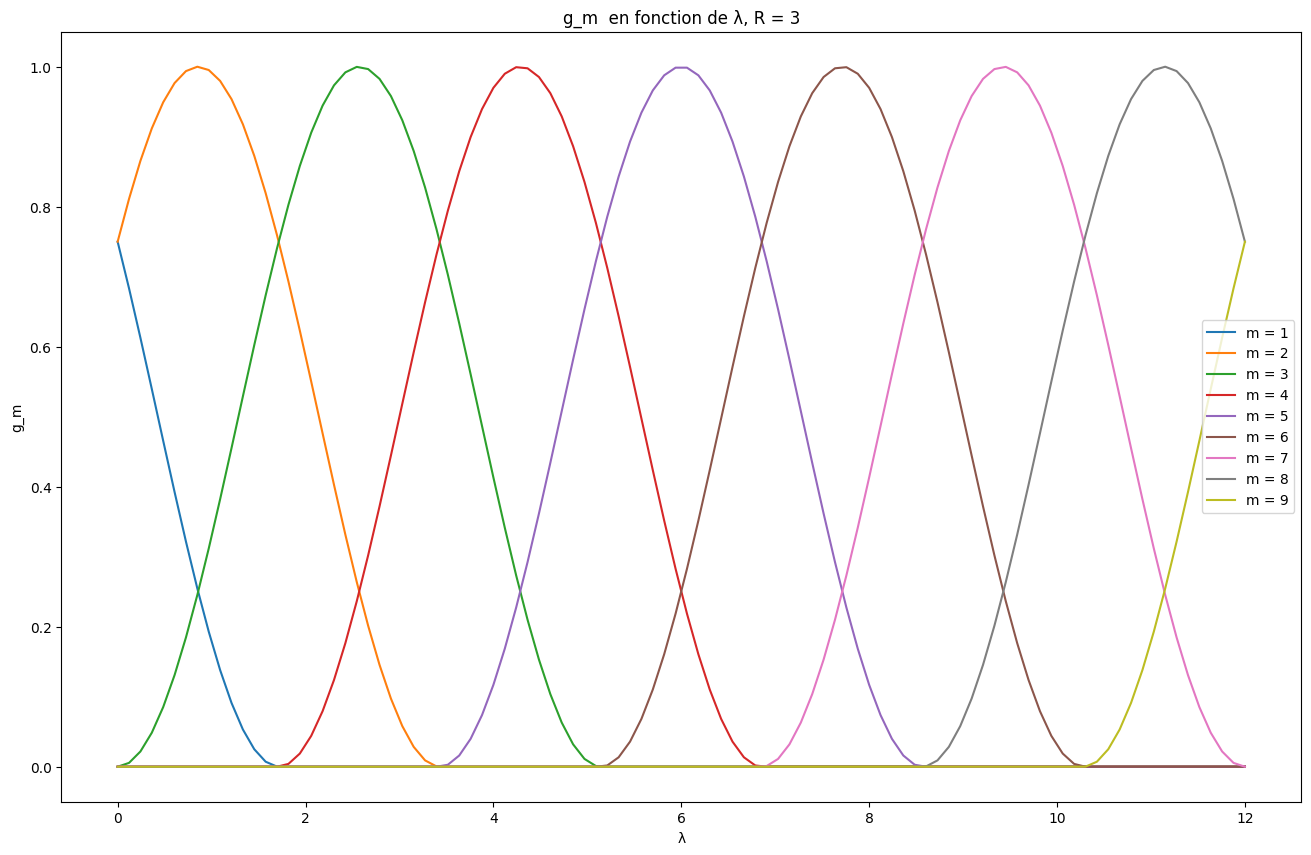

In [159]:
R = 3

plt.figure(figsize=(16, 10))
for m in range(1, M+1):
    plt.plot(λ,[g_m(m, lbd, λ_n, M, R) for lbd in λ], label = f"m = {m}")
plt.xlabel("λ")
plt.ylabel("g_m")
plt.title(label=f"g_m  en fonction de λ, R = {R}")
plt.legend()

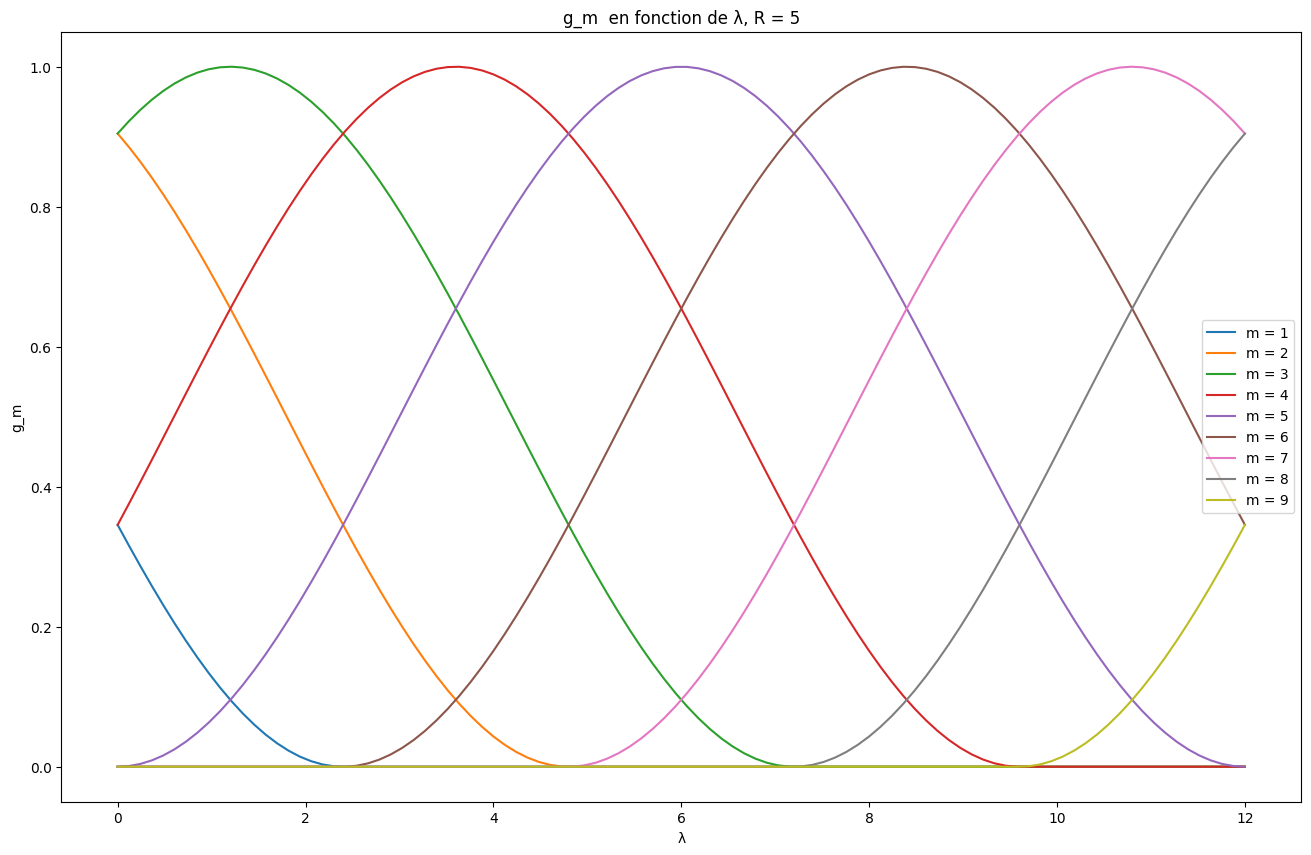

In [160]:
R = 5

plt.figure(figsize=(16, 10))
for m in range(1, M+1):
    plt.plot(λ,[g_m(m, lbd, λ_n, M, R) for lbd in λ], label = f"m = {m}")
plt.xlabel("λ")
plt.ylabel("g_m")
plt.title(label=f"g_m  en fonction de λ, R = {R}")
plt.legend()

On remarque que lorsque R augmente, le support des fonctions $g_m$ augmente. 

## Question 4

In [8]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
from collections import Counter
from tqdm.notebook import tqdm
from math import asin, cos, radians, sin, sqrt

from scipy.spatial.distance import pdist, squareform

In [9]:
data_df, stations_df, description = load_molene_meteo_dataset()
temperature_df = data_df.pivot(index="date", values="t", columns="station_name")

### Remove all stations with missing values in the temperature.

In [134]:
null_values_station_df = temperature_df.isna().sum(axis=0)
null_values_station_df = null_values_station_df[null_values_station_df==0]
stations_to_keep = null_values_station_df.index.to_numpy()
stations_to_keep

array(['AURAY', 'BELLE ILE-LE TALUT', 'BIGNAN', 'DINARD', 'GUERANDE',
       'GUISCRIFF SA', 'ILE DE GROIX', 'ILE-DE-BREHAT', 'KERPERT',
       'LORIENT-LANN BIHOUE', 'LOUARGAT', 'MERDRIGNAC', 'MORLAIX_AERO',
       'NOIRMOUTIER EN', 'PLEUCADEUC', 'PLEYBER-CHRIST SA', 'PLOERMEL',
       'PLOUGUENAST', "PLOUMANAC'H", 'PLOVAN', 'POMMERIT-JAUDY',
       'PONTIVY', 'PTE DE CHEMOULIN', 'PTE DE PENMARCH', 'PTE DU RAZ',
       'QUINTENIC', 'ROSTRENEN', 'SAINT-CAST-LE-G', 'SAINT-JOACHIM_SAE',
       'SARZEAU SA', 'SIBIRIL S A', 'SPEZET', 'ST BRIEUC', 'ST-SEGAL S A',
       'THEIX', 'TREGUNC', 'VANNES-SENE'], dtype=object)

In [135]:
filtered_data_df = data_df[data_df.station_name.isin(stations_to_keep)]
temperature_df = temperature_df[stations_to_keep]
filtered_stations_df = stations_df[stations_df.Nom.isin(stations_to_keep)]

### Construct the graph using the distance matrix and exponential smoothing (use the median heuristics for the bandwidth parameter).

In [136]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix ** 2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [145]:
stations_np = filtered_stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

# Median Heuristic
sigma = np.median(dist_mat_condensed) 

# List of thresholds
thresholds = np.arange(0,1,0.01)

average_degree=[]
for threshold in thresholds : 
  # Compute adjacency matrix
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
  
  # Compute average degree 
  average_degree.append(np.mean(adjacency_matrix_gaussian.sum(axis=1)))

plot_estim(average_degree, np.full(len(average_degree), 3), title = "<b>Average degree in function of threshold</b>", name1 = "Average degree", name2 = "y=3")

The graph is connected, and the average degree is equal to 3.664 with a threshold of 0.83


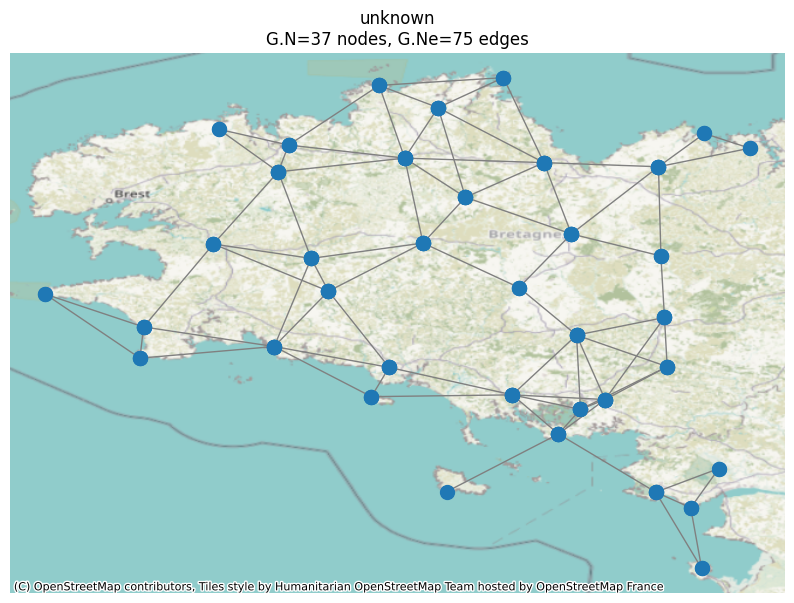

In [146]:
# Convert pandas df to geopandas df
CRS = "EPSG:4326"
stations_gdf = geopandas.GeoDataFrame(
    filtered_stations_df,
    geometry= geopandas.points_from_xy(
        filtered_stations_df.Longitude, filtered_stations_df.Latitude
    ),
).set_crs(CRS)

# Compute the minimum threshold 
min_threshold = 0
for threshold in thresholds[::-1] : 
    adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    average_degree = np.mean(adjacency_matrix_gaussian.sum(axis=1))
    min_threshold = threshold 
    if G_gaussian.is_connected(recompute=True) and average_degree >= 3 :
        print(f"The graph is{'not ' if not G_gaussian.is_connected(recompute=True) else ''} connected, and the average degree is equal to {round(average_degree,3)} with a threshold of {round(threshold,2)}")
        break

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

### What is the time where the signal is the least smooth?

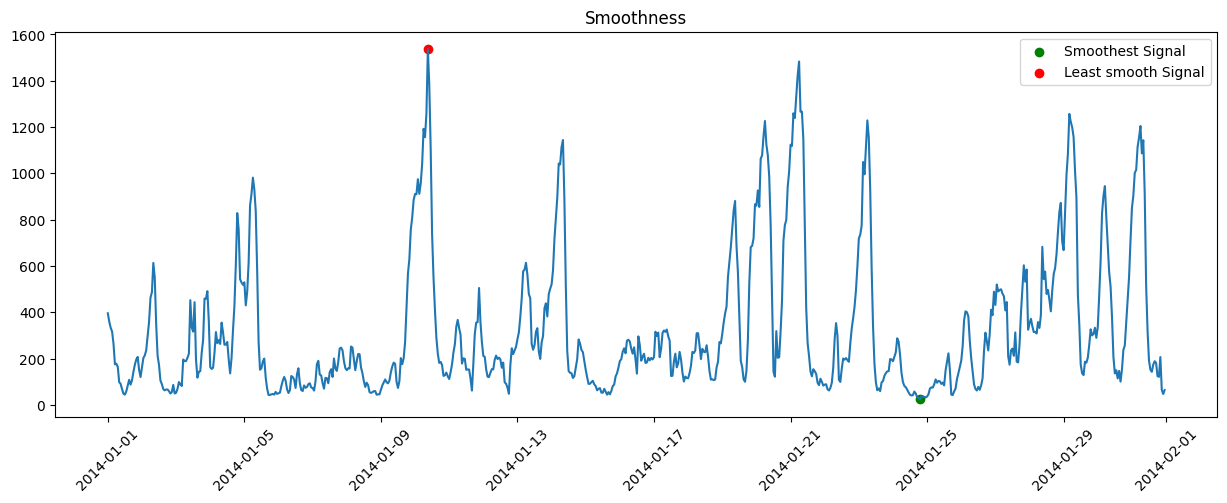



Time where the signal is the smoothest: 2014-01-24 19:00:00
Time where the signal is the least smooth: 2014-01-10 09:00:00


In [151]:
temperature_df = filtered_data_df.pivot(index="date", values="t", columns="station_name")
smoothness = []
laplacian_matrix = G_gaussian.L.todense()
for hour in temperature_df.index:
    signal = temperature_df.loc[hour].to_numpy()
    smths = float(signal.T.dot(laplacian_matrix).dot(signal))
    smoothness.append(smths)

smoothest_signal = {
    'date': temperature_df.index[np.argmin(smoothness)],
    'value' :np.min(smoothness)
}

least_smooth_signal = {
    'date': temperature_df.index[np.argmax(smoothness)],
    'value' :np.max(smoothness)
}

plt.figure(figsize=(15,5))
plt.plot(temperature_df.index, smoothness)
plt.scatter(smoothest_signal['date'],smoothest_signal['value'] , c='g', label = 'Smoothest Signal')
plt.scatter(least_smooth_signal['date'],least_smooth_signal['value'] , c='r', label = 'Least smooth Signal')
plt.legend()
plt.title('Smoothness')
plt.xticks(rotation=45)
plt.show()

print(f"\n\nTime where the signal is the smoothest: {temperature_df.index[np.argmin(smoothness)]}")
print(f"Time where the signal is the least smooth: {temperature_df.index[np.argmax(smoothness)]}")

In [153]:
signal = temperature_df.loc[smoothest_signal['date']].to_numpy()
signal

array([285.55, 284.25, 284.35, 283.85, 284.25, 283.95, 283.95, 283.95,
       283.35, 284.85, 284.05, 283.85, 284.25, 283.65, 284.65, 283.95,
       284.45, 283.45, 284.15, 284.45, 284.15, 284.95, 284.25, 284.35,
       284.15, 283.95, 283.45, 283.55, 284.35, 284.15, 284.25, 284.15,
       283.95, 284.55, 284.55, 284.85, 284.35])

### Question 5

In [ ]:
def classify_signal(hour):
    signal = temperature_df.loc[hour].to_numpy()

    adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, min_threshold))
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    laplacian_matrix = G_gaussian.L.todense()
    eigenvalues, eigenvectors = scipy.linalg.eig(laplacian_matrix)
    eigenvalues = np.real(eigenvalues)
    
    sorted_indexes = eigenvalues.argsort()
    eigenvalues = eigenvalues[sorted_indexes]
    eigenvectors = eigenvectors[:,sorted_indexes]

